In [ ]:
# Basic/Essential Libraries to import

import warnings
warnings.filterwarnings("ignore")
import os
import shutil
from collections import Counter
import codecs# this is used for file operations 
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime 
import time
import sqlite3
from sqlalchemy import create_engine # database connection
import pickle
import joblib
from joblib import dump, load
from sklearn.preprocessing import StandardScaler

In [ ]:
# Importing essential libraries for performing NLP

import re
import nltk
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import spacy
from tqdm import tqdm
from  wordcloud import WordCloud

In [ ]:
# Importing essential libraries for machine learning models

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import svc
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score


In [ ]:
df = pd.read_csv('training_variants')

In [ ]:
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
df.shape

(3321, 4)

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


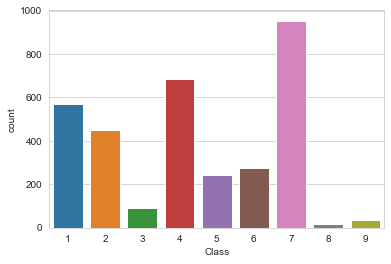

In [ ]:
print(df['Class'].value_counts())
g = sns.countplot(data = df,x = 'Class')

In [ ]:
print(len(df['Gene'].unique()))
#g = sns.countplot(data = df,x = 'Class')

264


In [ ]:
df_text = pd.read_csv('training_text',sep = '\|\|',names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', df_text.shape[0])
print('Number of features : ', df_text.shape[1])
print('Features : ', df_text.columns.values)
df_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        df_text[column][index] = string

In [ ]:
#text processing stage.
start_time = time.clock()
for index, row in df_text.iterrows(): ## iterate over the dataframe rowwise
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 48.444796999999994 seconds


In [ ]:
df_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
#merging both gene_variations and text data based on ID

result = pd.merge(df,df_text,on = 'ID',how = 'left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
duplicate = result[result.duplicated()]
duplicate

,ID,Gene,Variation,Class,TEXT


In [ ]:
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [ ]:
nan_rows = result[result.isnull().any(1)]
print (nan_rows.shape)

(5, 5)


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result.Gene + result.Variation

In [ ]:
nan_rows = result[result.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [ID, Gene, Variation, Class, TEXT]
Index: []


In [ ]:
result.TEXT.tail()

3316    introduction myelodysplastic syndromes mds het...
3317    introduction myelodysplastic syndromes mds het...
3318    runt related transcription factor 1 gene runx1...
3319    runx1 aml1 gene frequent target chromosomal tr...
3320    frequent mutations associated leukemia recurre...
Name: TEXT, dtype: object

In [ ]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, x_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
x_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print('Number of data points in train data:', x_train.shape[0])
print('Number of data points in test data:', x_test.shape[0])
print('Number of data points in cross validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Number of data points in class 1 : 609 ( 28.672 %)
Number of data points in class 2 : 439 ( 20.669 %)
Number of data points in class 3 : 363 ( 17.09 %)
Number of data points in class 4 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 6 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 8 : 24 ( 1.13 %)
Number of data points in class 9 : 12 ( 0.565 %)


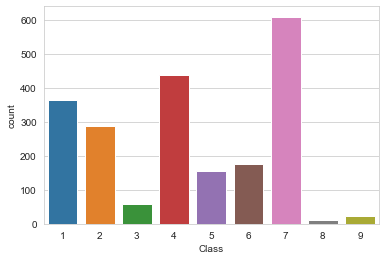

In [ ]:
train_class_distribution = x_train['Class'].value_counts()
#print(train_class_distribution)
g = sns.countplot(data = x_train,x = 'Class')
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')


Number of data points in class 1 : 153 ( 28.759 %)
Number of data points in class 2 : 110 ( 20.677 %)
Number of data points in class 3 : 91 ( 17.105 %)
Number of data points in class 4 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 6 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 8 : 6 ( 1.128 %)
Number of data points in class 9 : 3 ( 0.564 %)


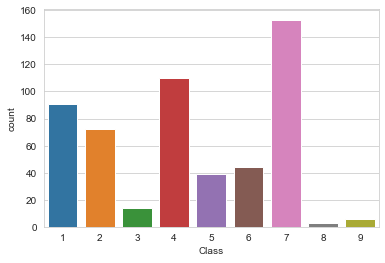

In [ ]:
cv_class_distribution = x_cv['Class'].value_counts()
g = sns.countplot(data = x_cv,x = 'Class')
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3), '%)')


In [ ]:
## Confusion Matrix with heatmap

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9] #-------------Change labels accordingly
  
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*50)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)"    , "-"*50)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


Log loss on CV Data using Random Model 2.5017206753233565
Log loss on Test Data using Random Model 2.4765563973565934
Number of misclassified points  89.02255639097744
-------------------- Confusion matrix --------------------------------------------------


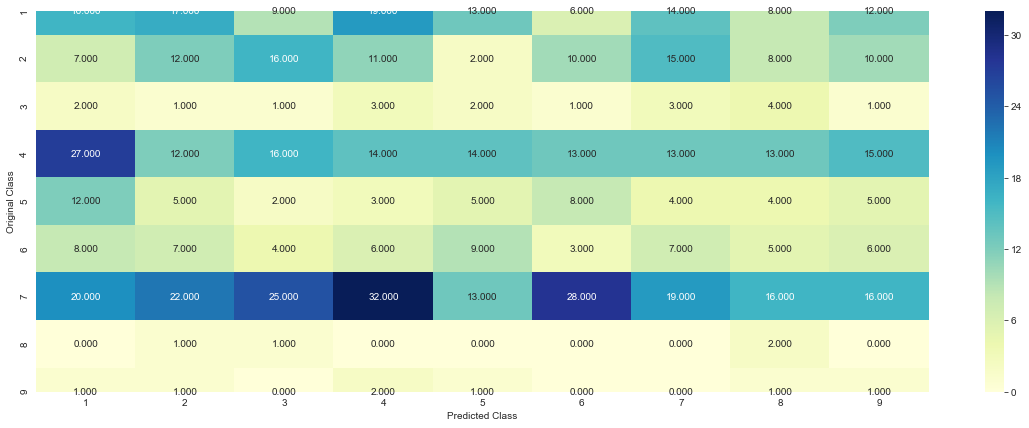

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


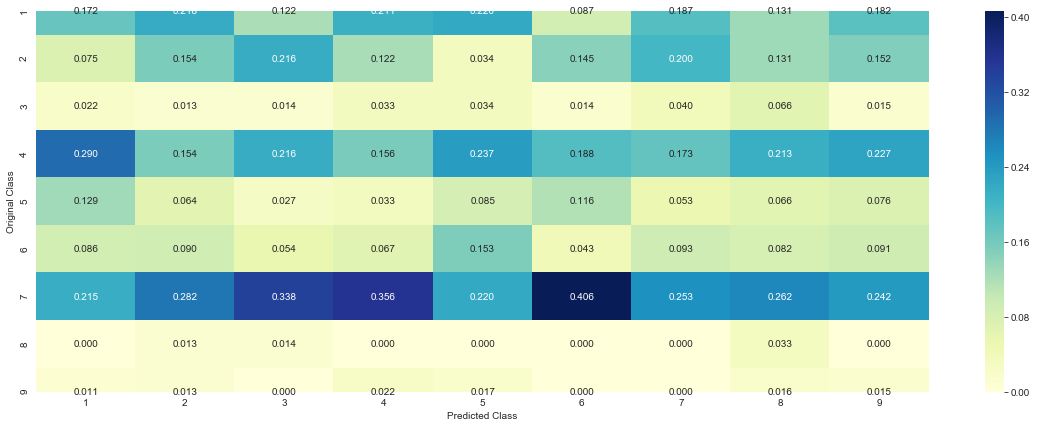

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


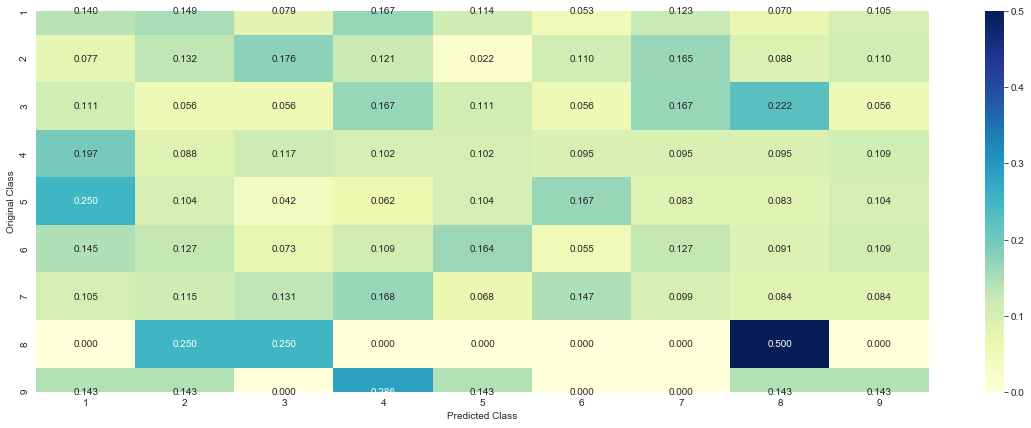

In [ ]:

#---------------------------------Computing log loss on random model for train/test dataset----------------------

test_len = len(y_test)
test_len_cv = len(y_cv)

# we create a output array that has exactly same size as the test data;#-- we can do this on train data also 

predict_y = np.zeros((test_len_cv,9)) # 9 here refers to no of class labels
for i in range(test_len_cv):
    rand_probs = np.random.rand(1,9)
    predict_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on CV Data using Random Model",log_loss(y_cv, predict_y, eps=1e-15)) 



# we create a output array that has exactly same size as the test data;#-- we can do this on train data also 

predict_y = np.zeros((test_len,9)) # 9 here refers to no of class labels
for i in range(test_len):
    rand_probs = np.random.rand(1,9)
    predict_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predict_y, eps=1e-15)) 

predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [ ]:
x_train.shape

(2124, 5)

In [ ]:
x_cv.shape

(532, 5)

In [ ]:
x_test.shape

(665, 5)

In [ ]:
x_tr_ge = x_train['Gene'].value_counts()
x_tr_ge.head(5)
len(x_tr_ge)

232

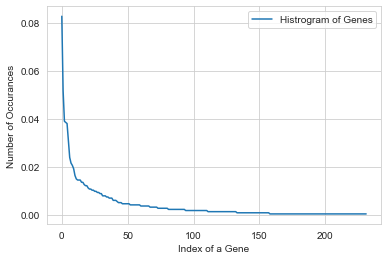

In [ ]:
s = sum(x_tr_ge.values);
h = x_tr_ge.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()


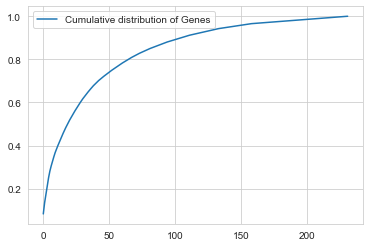

In [ ]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.legend()
plt.show()

In [ ]:
# converting Gene feature to numeric vector using One hot encoding

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [ ]:
train_gene_feature_onehotCoding.shape #--------sparse matrix

(2124, 231)

In [ ]:
# Conversion of Gene feature to numeric vector using response coding or mean replacement method

def get_gv_fea_dict(alpha, feature, df):
    value_count = df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10): #-------------no of class labels
            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]) #-------------no of class labels
    return gv_fea

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [ ]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [ ]:
train_gene_feature_responseCoding[0]

array([0.09090909, 0.20909091, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.15454545, 0.09090909, 0.09090909])

For values of alpha =  1e-05  ; The log loss is: 1.4093323815908763
For values of alpha =  0.0001  ; The log loss is: 1.4467771210926077
For values of alpha =  0.001  ; The log loss is: 1.5087842348047105
For values of alpha =  0.01  ; The log loss is: 1.5400288941053695
For values of alpha =  0.1  ; The log loss is: 1.5451659566271743
For values of alpha =  1  ; The log loss is: 1.541765170630282


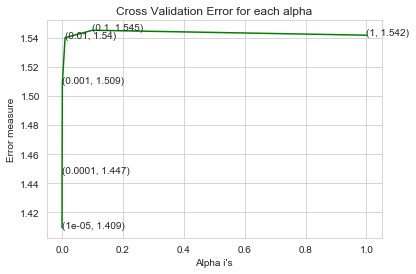

For values of best alpha =  1e-05  ; The train log loss is: 1.1705387775520864
For values of best alpha =  1e-05  ; The CV log loss is: 1.4093323815908763
For values of best alpha =  1e-05  ; The test log loss is: 1.2943119097404805


In [ ]:

##---------------------- SGD Classifier with Logistic Regression with metric Logloss ------------


# when we use logloss as metric we must use calibrated classifier for correct prob

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for Logistic Regression.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    log_error_array.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, " ; The log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

#--------------------------------------------PLOT of CV error-------------------------- 

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#---------------------------------------------------


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

y_pred = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The train log loss is:",log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The CV log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The test log loss is:",log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05  ; The log loss is: 1.2905198852823283
For values of alpha =  0.0001  ; The log loss is: 1.2529559734868214
For values of alpha =  0.001  ; The log loss is: 1.3780243008924926
For values of alpha =  0.01  ; The log loss is: 1.6826708375766954
For values of alpha =  0.1  ; The log loss is: 1.830259980722315
For values of alpha =  1  ; The log loss is: 1.8302599806232394


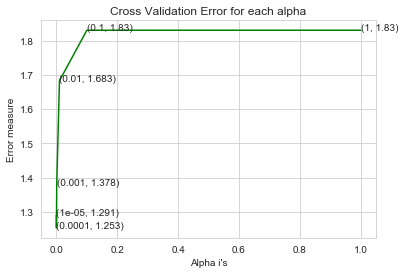

For values of best alpha =  0.0001  ; The train log loss is: 1.0035830585220546
For values of best alpha =  0.0001  ; The CV log loss is: 1.2529559734868214
For values of best alpha =  0.0001  ; The test log loss is: 1.1676471848503713


In [ ]:

##---------------------- SGD Classifier with Logistic Regression(L1 penalty) with metric Logloss ------------


# when we use logloss as metric we must use calibrated classifier for correct prob

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for Logistic Regression.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    log_error_array.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, " ; The log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

#--------------------------------------------PLOT of CV error-------------------------- 

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#---------------------------------------------------


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

y_pred = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The train log loss is:",log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The CV log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The test log loss is:",log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))


In [ ]:
# to check how much variation btwn train,cv n test data dist

test_coverage=x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage=x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
print(test_coverage,'data points out of',x_test.shape[0] ,'data points are found in test data:', (test_coverage/x_test.shape[0])*100)
print(cv_coverage, 'data pointsout of',x_cv.shape[0],'data points are found in cross validation data:',(cv_coverage/x_cv.shape[0])*100)

646 data points out of 665 data points are found in test data: 97.14285714285714
513 data pointsout of 532 data points are found in cross validation data: 96.42857142857143


In [ ]:
x_tr_ge = x_train['Variation'].value_counts()
len(x_tr_ge)

1939

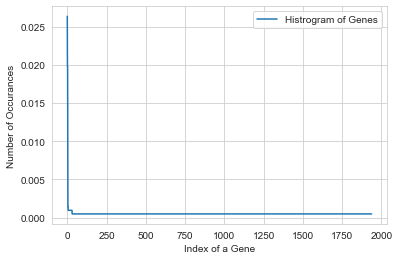

In [ ]:
s = sum(x_tr_ge.values);
h = x_tr_ge.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()


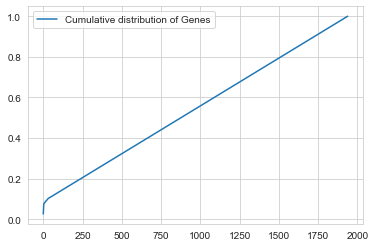

In [ ]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.legend()
plt.show()

In [ ]:
# converting Variation feature to numeric vector using One hot encoding

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1969)

In [ ]:
# converting Variation feature to numeric vector using response coding
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [ ]:
train_variation_feature_responseCoding.shape

(2124, 9)

For values of alpha =  1e-05  ; The log loss is: 1.7228705033978344
For values of alpha =  0.0001  ; The log loss is: 1.7197423251309036
For values of alpha =  0.001  ; The log loss is: 1.7391528002675882
For values of alpha =  0.01  ; The log loss is: 1.7988609100878843
For values of alpha =  0.1  ; The log loss is: 1.830259980722542
For values of alpha =  1  ; The log loss is: 1.8302599806232394


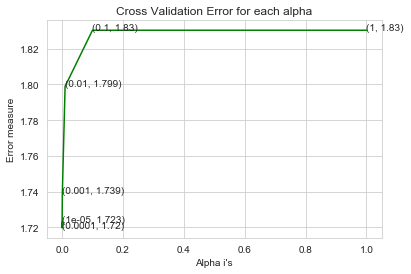

For values of best alpha =  0.0001  ; The train log loss is: 0.9286970372943295
For values of best alpha =  0.0001  ; The CV log loss is: 1.7197423251309036
For values of best alpha =  0.0001  ; The test log loss is: 1.7063599420197368


In [ ]:

##---------------------- SGD Classifier with Logistic Regression with metric Logloss ------------


# when we use logloss as metric we must use calibrated classifier for correct prob

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for Logistic Regression.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    y_pred = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    log_error_array.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, " ; The log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

#--------------------------------------------PLOT of CV error-------------------------- 

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#---------------------------------------------------


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

y_pred = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The train log loss is:",log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The CV log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The test log loss is:",log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))


In [ ]:
# to check how much variation btwn train,cv n test data dist

test_coverage=x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage=x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
print(test_coverage,'data points out of',x_test.shape[0] ,'data points are found in test data:', (test_coverage/x_test.shape[0])*100)
print(cv_coverage, 'data pointsout of',x_cv.shape[0],'data points are found in cross validation data:',(cv_coverage/x_cv.shape[0])*100)

82 data points out of 665 data points are found in test data: 12.330827067669173
53 data pointsout of 532 data points are found in cross validation data: 9.962406015037594


In [ ]:
x_train.TEXT.head(5)

1284    three dimensional structure complex human h ra...
1266    abstract bladder cancers commonly show genetic...
2580    published analyses effects missense mutations ...
1027    report clinical manifestations functional aspe...
2128    activities cyclin dependent kinases serve inte...
Name: TEXT, dtype: object

In [ ]:

tfidf_tr = TfidfVectorizer(min_df = 3)
train_text_feature_onehotCoding = tfidf_tr.fit_transform(x_train['TEXT'])
tags = tfidf_tr.get_feature_names()
word2tfidf_tr = dict(zip(tags, tfidf_tr.idf_))

In [ ]:
train_text_feature_onehotCoding.shape

(2124, 54022)

In [ ]:
len(tags)

54022

In [ ]:
from sklearn.preprocessing import normalize
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = tfidf_tr.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = tfidf_tr.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05  ; The log loss is: 1.3942014376352019
For values of alpha =  0.0001  ; The log loss is: 1.3243333468218732
For values of alpha =  0.001  ; The log loss is: 1.4057950434869972
For values of alpha =  0.01  ; The log loss is: 1.8302599805012412
For values of alpha =  0.1  ; The log loss is: 1.8302599807220452
For values of alpha =  1  ; The log loss is: 1.8302599806232394


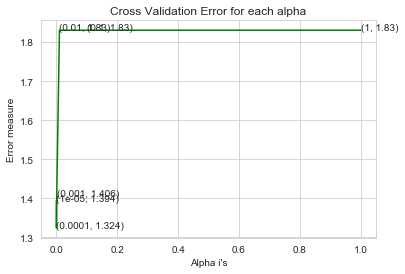

For values of best alpha =  0.0001  ; The train log loss is: 0.9658592534895938
For values of best alpha =  0.0001  ; The CV log loss is: 1.3243333468218732
For values of best alpha =  0.0001  ; The test log loss is: 1.2503583348011462


In [ ]:

##---------------------- SGD Classifier with Logistic Regression with metric Logloss ------------


# when we use logloss as metric we must use calibrated classifier for correct prob

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for Logistic Regression.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    y_pred = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    log_error_array.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, " ; The log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

#--------------------------------------------PLOT of CV error-------------------------- 

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#---------------------------------------------------


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

y_pred = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The train log loss is:",log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The CV log loss is:",log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], " ; The test log loss is:",log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))


In [ ]:
# to check how much variation btwn train,cv n test data dist

test_coverage=x_test[x_test['TEXT'].isin(list(set(x_train['TEXT'])))].shape[0]
cv_coverage=x_cv[x_cv['TEXT'].isin(list(set(x_train['TEXT'])))].shape[0]
print(test_coverage,'data points out of',x_test.shape[0] ,'data points are found in test data:', (test_coverage/x_test.shape[0])*100)
print(cv_coverage, 'data pointsout of',x_cv.shape[0],'data points are found in cross validation data:',(cv_coverage/x_cv.shape[0])*100)

346 data points out of 665 data points are found in test data: 52.03007518796993
253 data pointsout of 532 data points are found in cross validation data: 47.556390977443606


In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

from scipy.sparse import hstack
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))


In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56222)
(number of data points * number of features) in test data =  (665, 56222)
(number of data points * number of features) in cross validation data = (532, 56222)


In [ ]:
test_x_onehotCoding.shape

(665, 56222)

for alpha = 1e-05
Log Loss : 1.363808955345403
for alpha = 0.0001
Log Loss : 1.3592971685396495
for alpha = 0.001
Log Loss : 1.3614249430881404
for alpha = 0.1
Log Loss : 1.3305137093499964
for alpha = 1
Log Loss : 1.3325851880300337
for alpha = 10
Log Loss : 1.4085538602858025
for alpha = 100
Log Loss : 1.3264185326976266
for alpha = 1000
Log Loss : 1.296256976641726


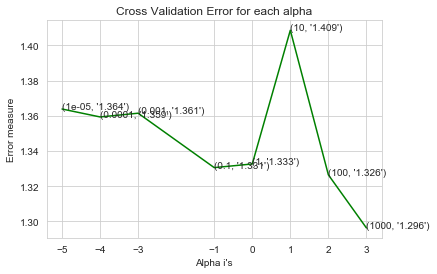

For values of best alpha =  1000 The train log loss is: 0.917395183584805
For values of best alpha =  1000 The cross validation log loss is: 1.296256976641726
For values of best alpha =  1000 The test log loss is: 1.1715878720925512


In [ ]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Number of misclassified points  44.3609022556391
-------------------- Confusion matrix --------------------------------------------------


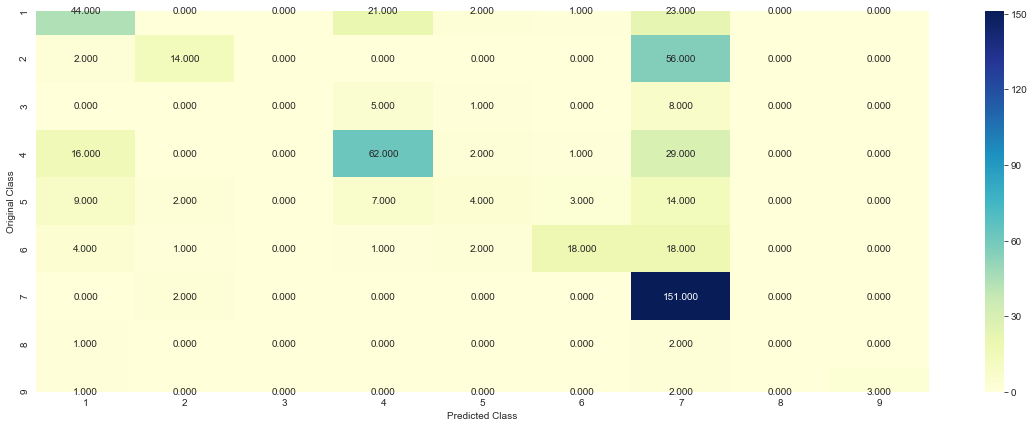

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


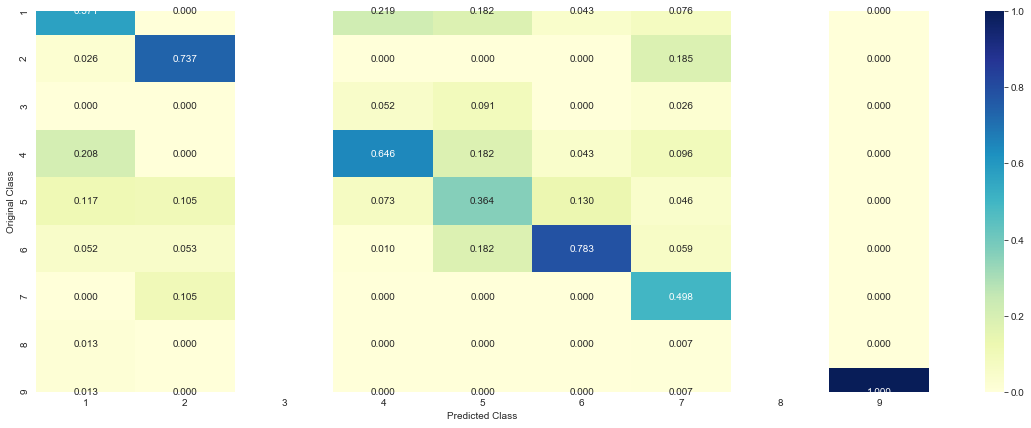

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


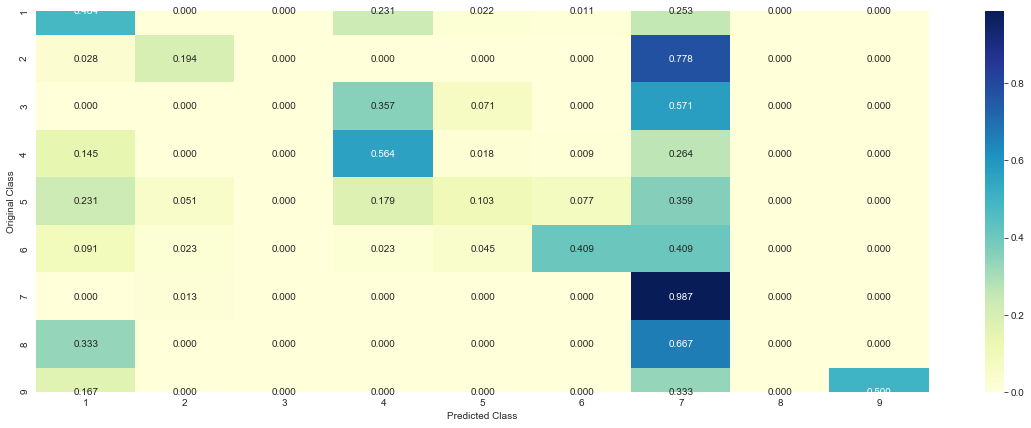

In [ ]:
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [ ]:
##------Feature importance,random check------------

test_point_index =9
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1156 0.0789 0.0098 0.1331 0.043  0.0944 0.5186 0.005  0.0017]]
Actual Class : 6
--------------------------------------------------


In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.410e-02 2.945e-01 1.000e-03 1.060e-02 1.110e-02 7.800e-03 6.587e-01
  2.100e-03 1.000e-04]]
Actual Class : 2
--------------------------------------------------


log_loss for k =  1 is 1.4160731891394491
log_loss for k =  3 is 1.3544630300765188
log_loss for k =  5 is 1.3679923056515126
log_loss for k =  7 is 1.3928841106931347
log_loss for k =  9 is 1.4277122007413166
log_loss for k =  11 is 1.4680828802724482
log_loss for k =  13 is 1.4932854556494746


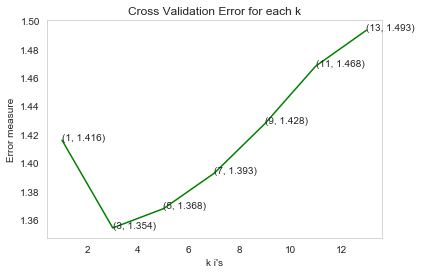

For values of best K =  3 The train log loss is: 0.9328053041683135
For values of best K =  3 The cross validation log loss is: 1.3544630300765188
For values of best K =  3 The test log loss is: 1.2507394361922797


In [ ]:
##-------------------------------KNN with Log Loss metric----------------------------

# when we use logloss as metric we must use calibrated classifier for correct prob


k = [x for x in range(1, 15, 2)] # k is the hyper paramater in KNN
cv_log_error_array=[]

for i in k:
    k_clf=KNeighborsClassifier(n_neighbors=i)
    k_clf.fit(train_x_onehotCoding,train_y)
    sig_clf = CalibratedClassifierCV(k_clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding,train_y)
    predict_y_cv = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, predict_y_cv, labels=k_clf.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',k[i],'is',cv_log_error_array[i])

best_k = np.argmin(cv_log_error_array)

#--------------------------------------------PLOT of CV error--------------------------    
fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],np.round(txt,3)), (k[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each k")
plt.xlabel("k i's")
plt.ylabel("Error measure")
plt.show()
#---------------------------------------------------------

k_clf=KNeighborsClassifier(n_neighbors=k[best_k])
k_clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(k_clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)
    
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print ('For values of best K = ', k[best_k], "The train log loss is:",log_loss(train_y, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best K = ', k[best_k], "The cross validation log loss is:",log_loss(cv_y, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best K = ', k[best_k], "The test log loss is:",log_loss(test_y, predict_y))


In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = k_clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), k[best_k])
print("The ",k[best_k]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 2
The  3  nearest neighbours of the test points belongs to classes [7 6 6]
Fequency of nearest points : Counter({6: 2, 7: 1})


Number of misclassified points  40.45112781954887
-------------------- Confusion matrix --------------------------------------------------


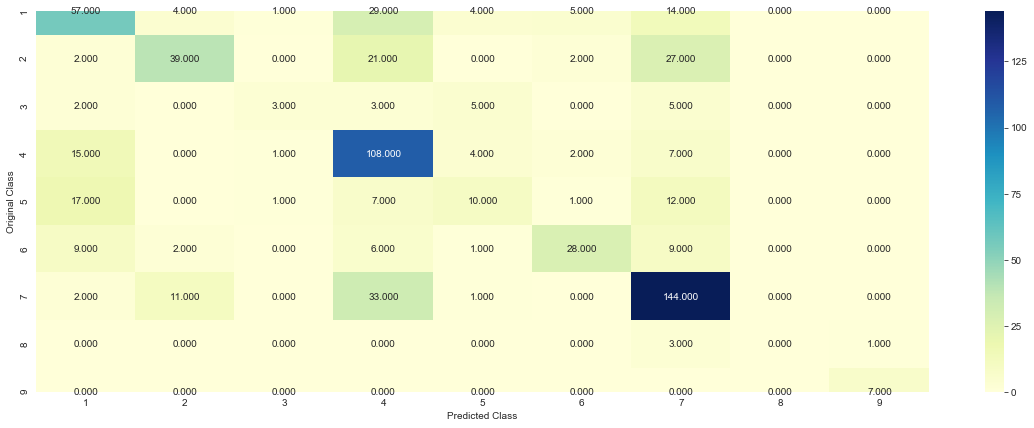

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


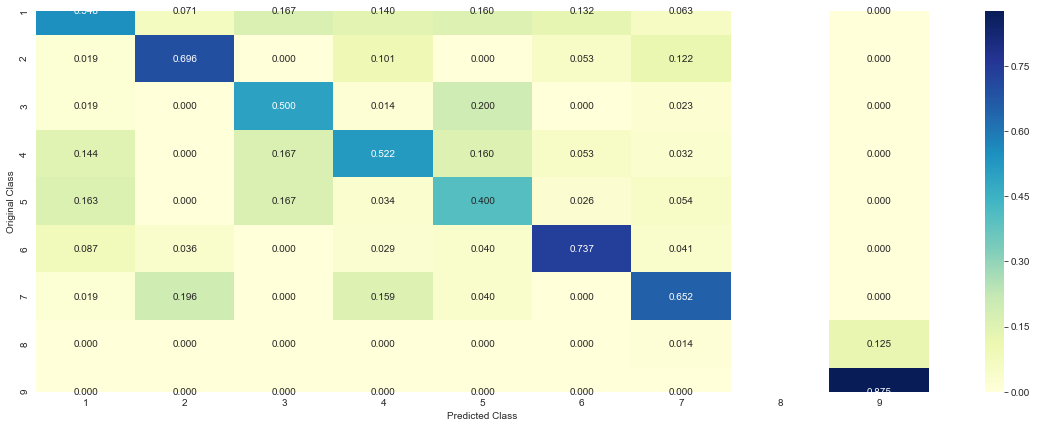

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


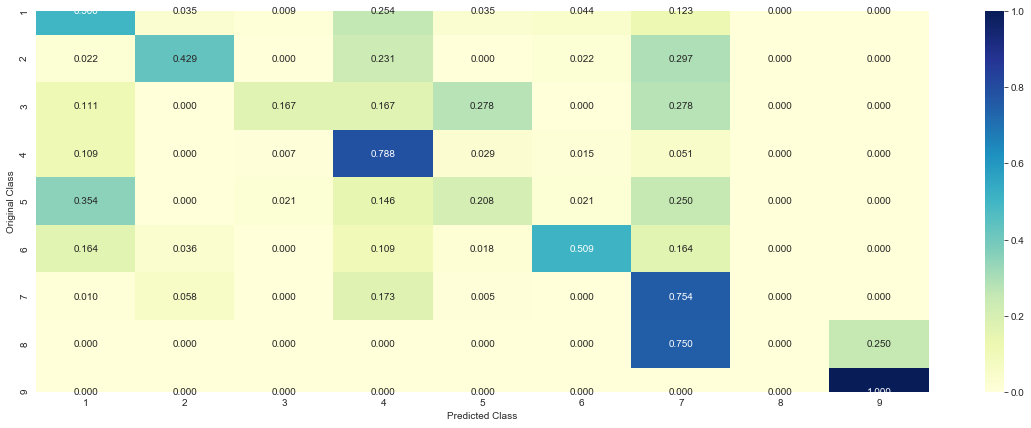

In [ ]:
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding))

for alpha = 1e-06
Log Loss : 1.338450240311951
for alpha = 1e-05
Log Loss : 1.2971147087305894
for alpha = 0.0001
Log Loss : 1.202076292159497
for alpha = 0.001
Log Loss : 1.2416373049004306
for alpha = 0.01
Log Loss : 1.303669200328507
for alpha = 0.1
Log Loss : 1.3839119668135338
for alpha = 1
Log Loss : 1.5521135252454403
for alpha = 10
Log Loss : 1.5758077622549314
for alpha = 100
Log Loss : 1.5781989404406807


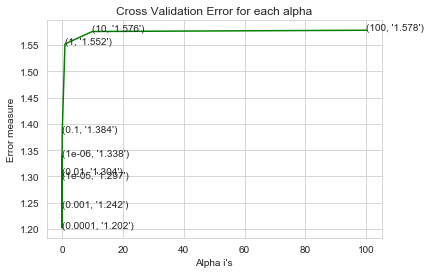

For values of best alpha =  0.0001 The train log loss is: 0.5499459542980112
For values of best alpha =  0.0001 The cross validation log loss is: 1.202076292159497
For values of best alpha =  0.0001 The test log loss is: 1.0652647232596593


In [ ]:
#-----------------SGDClassifier with log loss--------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Number of misclassified points  34.73684210526316
-------------------- Confusion matrix --------------------------------------------------


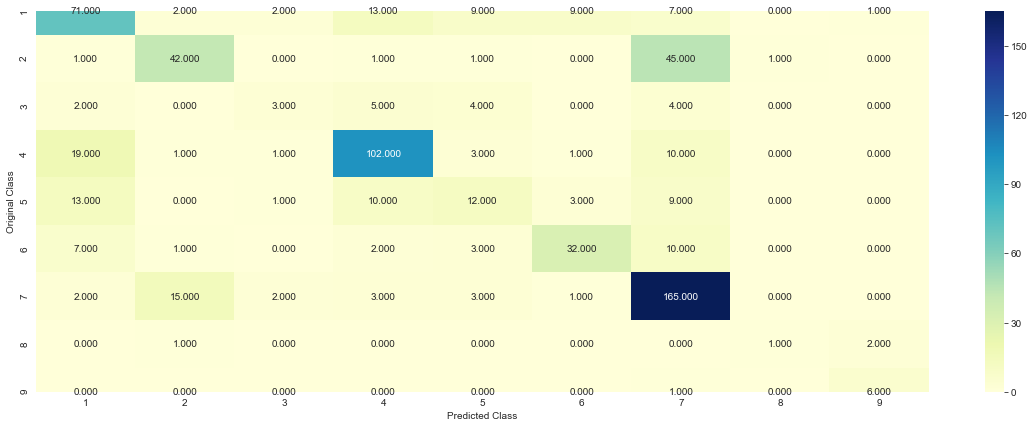

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


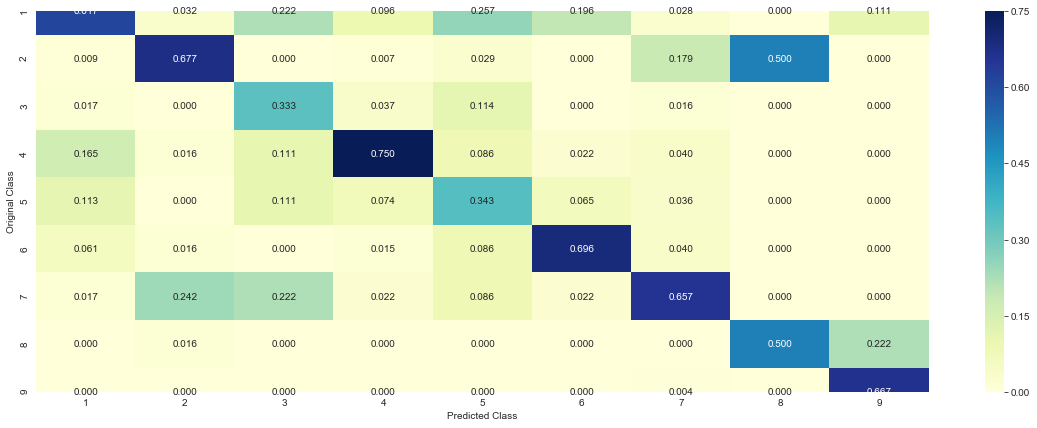

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


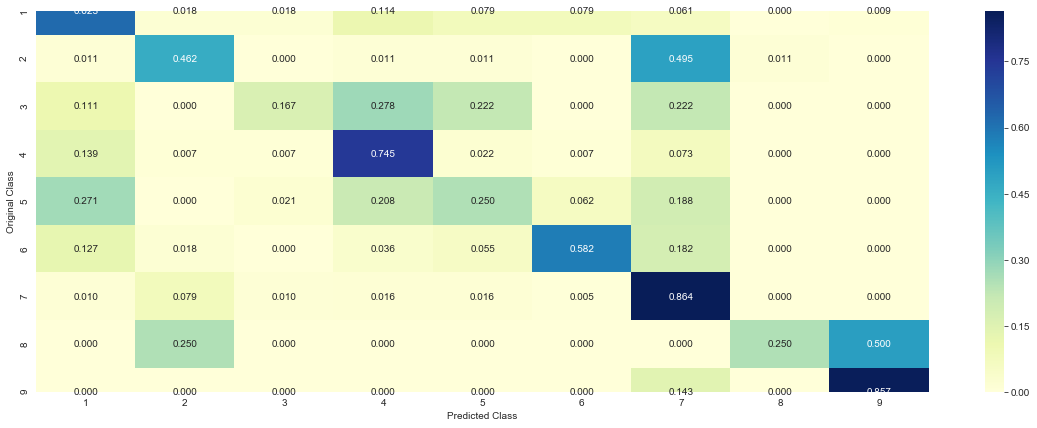

In [ ]:
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding))

In [ ]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 2
Predicted Class Probabilities: [[0.009  0.4862 0.0052 0.0075 0.0069 0.0056 0.4658 0.007  0.0067]]
Actual Class : 2
--------------------------------------------------


for C = 1e-05
Log Loss : 1.3145420923104518
for C = 0.0001
Log Loss : 1.290863820071266
for C = 0.001
Log Loss : 1.2196953936721444
for C = 0.01
Log Loss : 1.2781293334908161
for C = 0.1
Log Loss : 1.3870067880622934
for C = 1
Log Loss : 1.5786022884640902
for C = 10
Log Loss : 1.5785985719706435
for C = 100
Log Loss : 1.5785985857186495


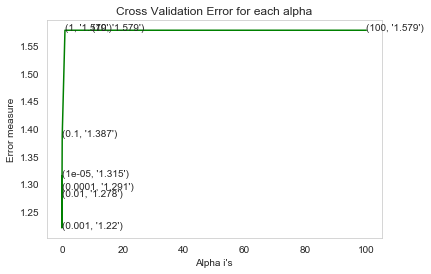

For values of best alpha =  0.001 The train log loss is: 0.5535948988174375
For values of best alpha =  0.001 The cross validation log loss is: 1.2196953936721444
For values of best alpha =  0.001 The test log loss is: 1.0720480913698582


In [ ]:
#-------------linear SVM----------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42) # class weights = 'bal'-- oversampling
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Number of misclassified points  34.285714285714285
-------------------- Confusion matrix --------------------------------------------------


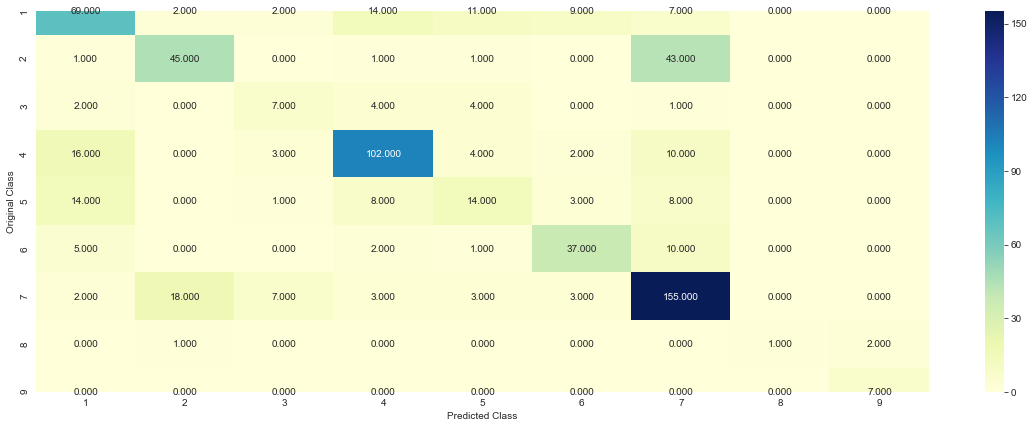

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


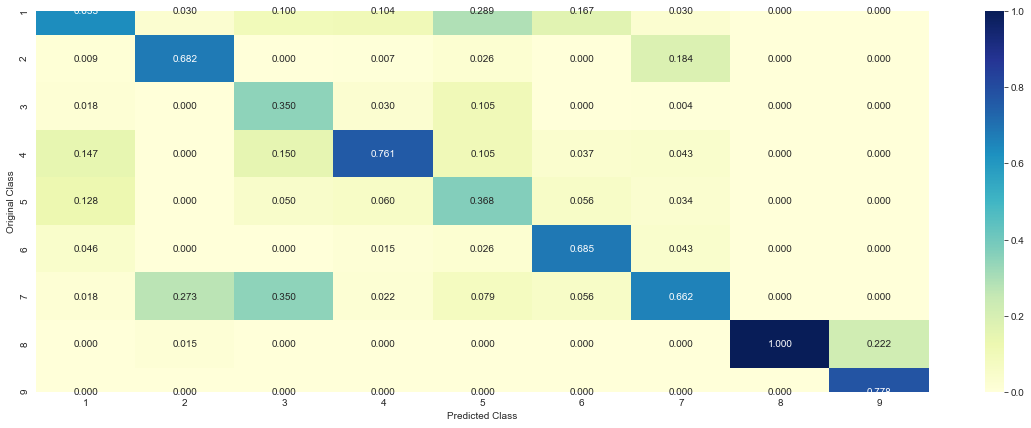

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


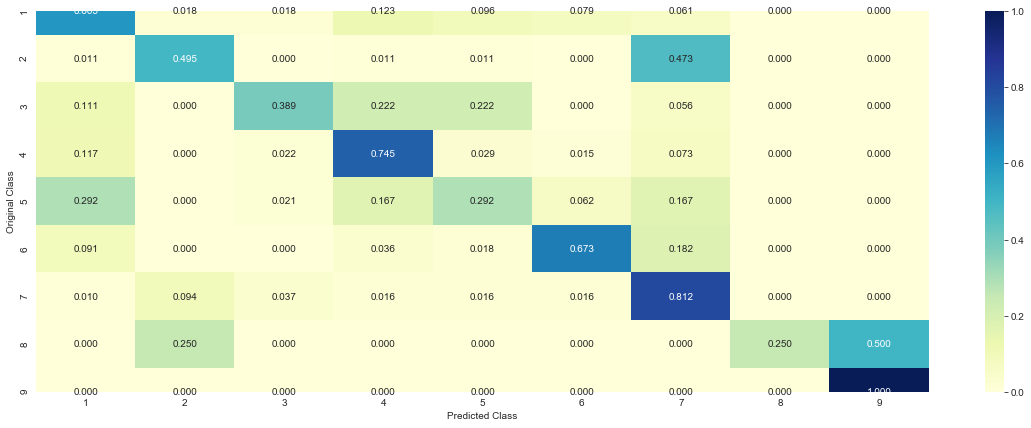

In [ ]:
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding))

In [ ]:
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0329 0.3296 0.003  0.0187 0.0054 0.0074 0.5977 0.0031 0.0023]]
Actual Class : 2
--------------------------------------------------


In [ ]:
#--------------- RandomForest classifier with  Randomsearch CV + log loss----------------


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 17)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

#print(random_grid)

model = RandomForestClassifier()

clf = RandomizedSearchCV(model,random_grid,scoring='neg_log_loss', \
                        n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs =-1)

op = clf.fit(train_x_onehotCoding,train_y)
op.best_params_

#-----------apply RF classifier with best parameters---------



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.9min finished
C:\Users\Chara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 925,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 25}

In [ ]:
#-----------apply RF classifier with best parameters---------

clf=RandomForestClassifier(n_estimators = 925, min_samples_split = 5,min_samples_leaf = 2,max_features = 'sqrt',max_depth = 25,random_state=42,n_jobs=-1)
clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y))


For values of best alpha =  0.001 The train log loss is: 0.5729612457838839
For values of best alpha =  0.001 The cross validation log loss is: 1.2664604914431632
For values of best alpha =  0.001 The test log loss is: 1.152853521325614


Number of misclassified points  36.390977443609025
-------------------- Confusion matrix --------------------------------------------------


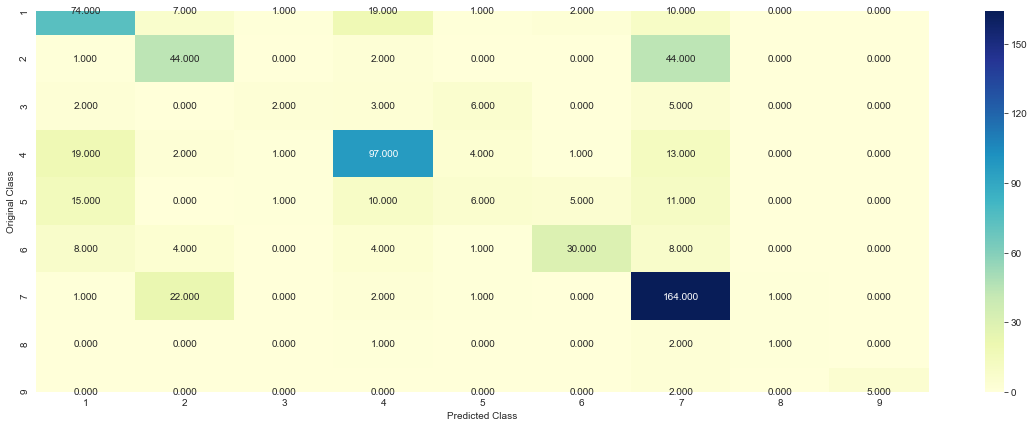

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


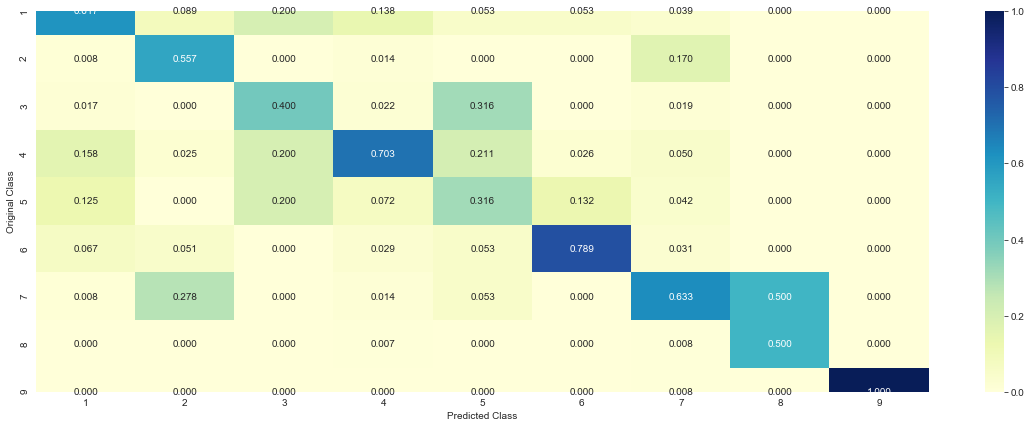

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


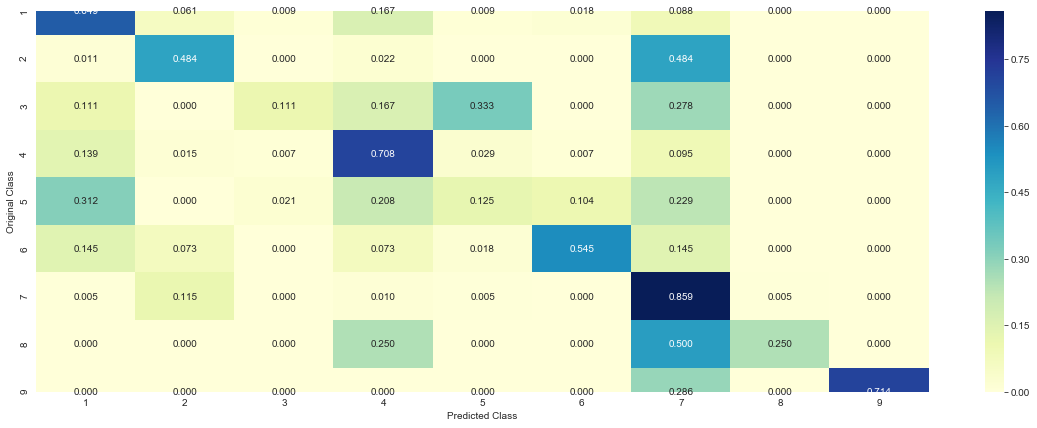

In [ ]:
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding))

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

Predicted Class : 2
Predicted Class Probabilities: [[0.0708 0.4036 0.0156 0.0543 0.0438 0.0348 0.3647 0.0065 0.0058]]
Actual Class : 2
--------------------------------------------------


In [ ]:
#-------------------Stacking of multiple models-------------------

from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)


# pickle file

import joblib
from joblib import dump, load
joblib.dump(clf1, 'sig_clf1.pkl') 
joblib.dump(clf2, 'sig_clf2.pkl') 
joblib.dump(clf3, 'sig_clf3.pkl') 

Logistic Regression :  Log Loss: 1.25
Support vector machines : Log Loss: 1.58
Naive Bayes : Log Loss: 1.36
--------------------------------------------------


['sig_clf3.pkl']

In [ ]:
from mlxtend.classifier import StackingClassifier

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.035
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.521
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.209
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.384
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.770


Log loss (train) on the stacking classifier : 0.6007793655445839
Log loss (CV) on the stacking classifier : 1.2088742482440893
Log loss (test) on the stacking classifier : 1.0676291371091833
Number of missclassified point : 0.3398496240601504
Number of misclassified points  33.98496240601504
-------------------- Confusion matrix --------------------------------------------------


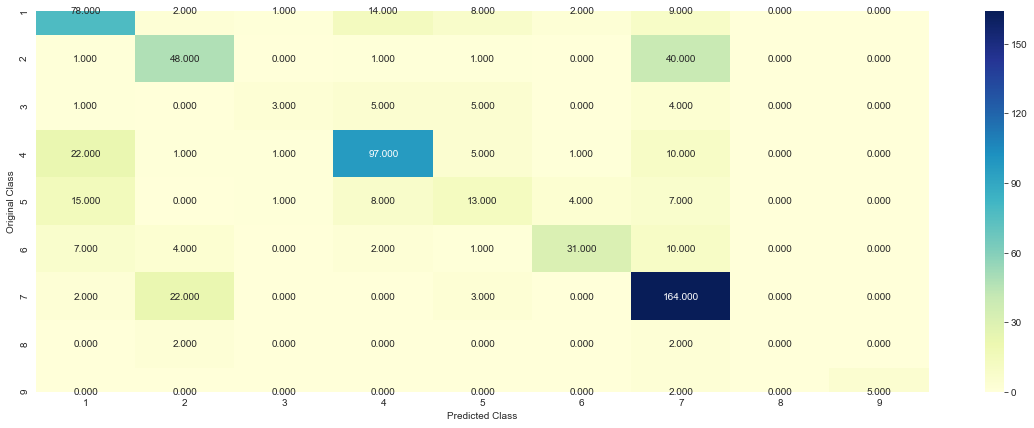

-------------------- Precision matrix (Columm Sum=1) --------------------------------------------------


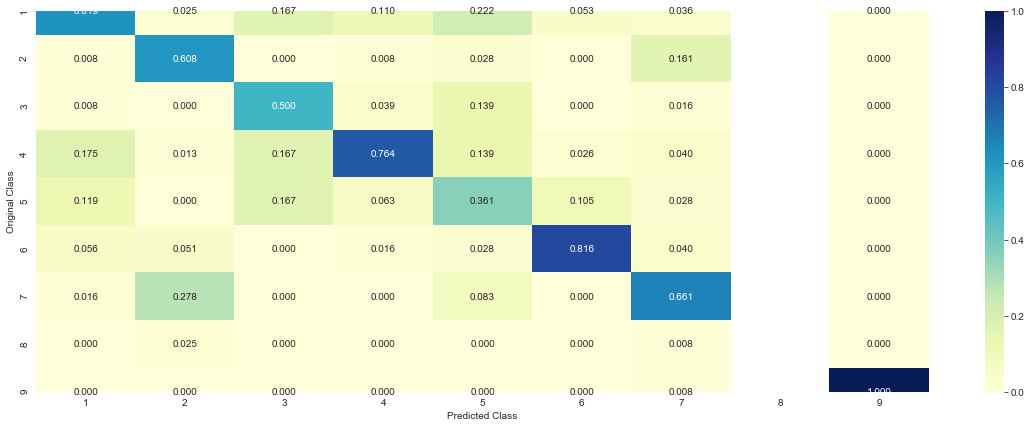

-------------------- Recall matrix (Row sum=1) --------------------------------------------------


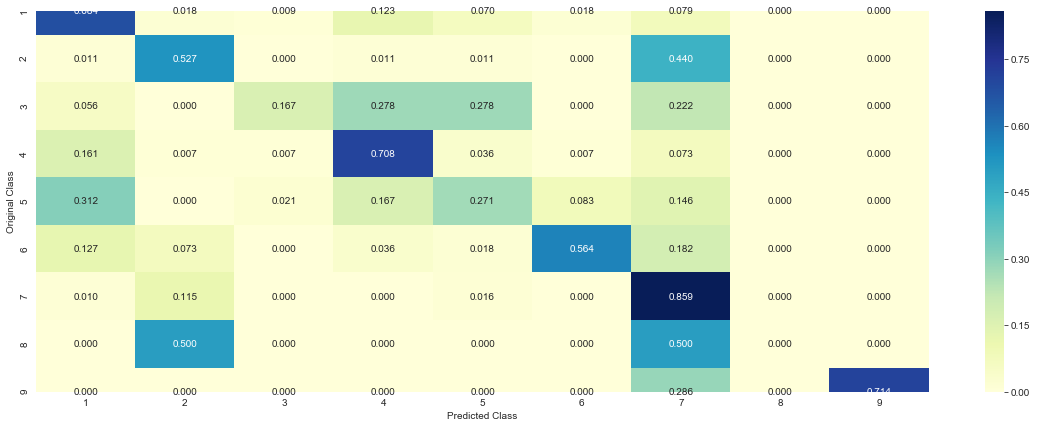

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))